In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import erfc, erfcinv
from scipy.optimize import minimize, curve_fit
import sympy

from pathlib import Path
from IPython.display import Image, display
import ipywidgets as widgets  # interactive display

import pyNN.nest as sim
import nest
import quantities as pq

from importlib import reload

import cell_library
import simulations

data_path = Path('/home/pavel/academia/mean-field-CSNG/data/')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Oct  8 2024 11:09:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Nov 15 15:51:11 Install [Info]: 
    loaded module PyNN extensions for NEST


In [2]:
reload(cell_library)
neurons = cell_library.load_zerlaut_model_parameters()

# Simulating neurons

In [3]:
neuron_name = 'zerlaut_exc'
sim_pars = neurons[neuron_name]
sim_pars

{'neuron_params': {'v_rest': -65.0,
  'v_reset': -65.0,
  'tau_refrac': 5.0,
  'tau_m': 15.0,
  'cm': 0.15,
  'e_rev_E': 0.0,
  'e_rev_I': -80.0,
  'tau_syn_E': 5.0,
  'tau_syn_I': 5.0,
  'a': 4.0,
  'b': 0.02,
  'delta_T': 2.0,
  'tau_w': 500.0,
  'v_thresh': -50.0},
 'exc_syn_params': {'weight': 1.0, 'delay': 1.0},
 'inh_syn_params': {'weight': 5.0, 'delay': 1.0},
 'exc_syn_number': 400,
 'inh_syn_number': 100,
 'synapse_type': 'static_synapse',
 'simulation_time': 1000.0,
 'poisson_input': True}

In [4]:
neuron_name = 'zerlaut_inh'
sim_pars = neurons[neuron_name]
sim_pars

{'neuron_params': {'v_rest': -65.0,
  'v_reset': -65.0,
  'tau_refrac': 5.0,
  'tau_m': 15.0,
  'cm': 0.15,
  'e_rev_E': 0.0,
  'e_rev_I': -80.0,
  'tau_syn_E': 5.0,
  'tau_syn_I': 5.0,
  'a': 0.0,
  'b': 0.0,
  'delta_T': 0.5,
  'tau_w': 500.0,
  'v_thresh': -50.0},
 'exc_syn_params': {'weight': 1.0, 'delay': 1.0},
 'inh_syn_params': {'weight': 5.0, 'delay': 1.0},
 'exc_syn_number': 400,
 'inh_syn_number': 100,
 'synapse_type': 'static_synapse',
 'simulation_time': 1000.0,
 'poisson_input': True}

In [5]:
reload(cell_library)
reload(simulations)

neurons = cell_library.load_zerlaut_model_parameters()

# nu_e_range = np.linspace(0, 40, 40)
# nu_i_range = np.linspace(0, 170, 40)
nu_e_range = np.linspace(0, 40, 10)
nu_i_range = np.linspace(0, 40, 10)

simulate = False

################################################################################

activities = dict()
adaptations = dict()

mu_Vs_sim = dict()
sigma_Vs_sim = dict()
tau_Vs_sim = dict()
membrane_potentials = dict()


if simulate:
    for neuron_name, sim_pars in neurons.items():
        print(neuron_name)
        tau_w = sim_pars['neuron_params']['tau_w']
        sim_time = sim_pars['simulation_time']
        if sim_time < tau_w*10:
            sim_pars['simulation_time'] = tau_w*10 

        activity = np.zeros((nu_e_range.size, nu_i_range.size))
        adaptation = np.zeros((nu_e_range.size, nu_i_range.size))
        mu_V = np.zeros((nu_e_range.size, nu_i_range.size))
        sigma_V = np.zeros((nu_e_range.size, nu_i_range.size))
        tau_V = np.zeros((nu_e_range.size, nu_i_range.size))

        for i, nu_e in enumerate(nu_e_range):
            for j, nu_i in enumerate(nu_i_range):
                membrane_potential, spike_times, w = simulations.simulate_neuron_pynn(nu_e, nu_i, **sim_pars)
                activity[i, j] = simulations.activity_from_spikes(spike_times, sim_pars['simulation_time'])
                adaptation[i, j] = np.mean(w[w.size//2:])
                
                membrane_potential = membrane_potential[membrane_potential.size//2:]
                mu_V[i,j] = np.mean(membrane_potential)
                sigma_V[i,j] = np.std(membrane_potential)
                # TODO: add tau_V calculation (check cell below)

        np.save(data_path / f'{neuron_name}-activity-{nu_e_range.size}x{nu_i_range.size}.npy', activity)
        np.save(data_path / f'{neuron_name}-adaptation-{nu_e_range.size}x{nu_i_range.size}.npy', adaptation)
        
        activities[neuron_name] = activity
        adaptations[neuron_name] = adaptation
        mu_Vs_sim[neuron_name] = mu_V
        sigma_Vs_sim[neuron_name] = sigma_V
        tau_Vs_sim[neuron_name] = tau_V

else:
    for neuron_name in neurons:
        activities[neuron_name] = np.load(data_path / f'{neuron_name}-activity-{nu_e_range.size}x{nu_i_range.size}.npy')
        adaptations[neuron_name] = np.load(data_path / f'{neuron_name}-adaptation-{nu_e_range.size}x{nu_i_range.size}.npy')

In [6]:
# NOTE: weird results check!
# tau_V is negative and super small
# also not sure which autocorrelation function to use!

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

def estimated_autocorrelation(x):
    # https://stackoverflow.com/questions/14297012
    # https://en.wikipedia.org/wiki/Autocorrelation
    # without normalization it should be called autovariation
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')
    result = r/(variance*n)
    return result[result.size//2:]

def estimate_tau_V(membrane_potential):
    # assert type(membrane_potential) == np.ndarray
    ac = estimated_autocorrelation(membrane_potential)
    tau_V = np.trapz(ac, dx=0.1)
    return tau_V

mu_V = np.mean(membrane_potential)
print(f"mu_V = {mu_V}")
sigma_V = np.std(membrane_potential)
print(f"sigma_V = {sigma_V}")
tau_V = estimate_tau_V(membrane_potential.squeeze())
print(f"tau_V = {tau_V}")

ac = autocorr(membrane_potential.magnitude.flatten())
plt.plot(ac/ac[0])
plt.show()

ac = estimated_autocorrelation(membrane_potential.squeeze())
plt.plot(ac)
plt.show()


NameError: name 'membrane_potential' is not defined

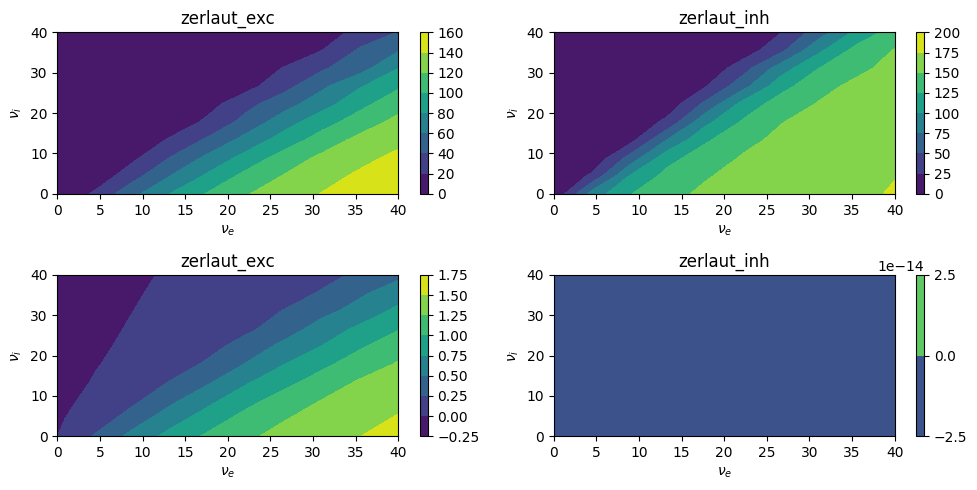

In [7]:
# plots the output activity

plt.figure(figsize=(10, 5))
for i, (neuron_name, activity) in enumerate(activities.items(), start=1):
    plt.subplot(2, 2, i)
    plt.contourf(nu_e_range, nu_i_range, activity.T)
    plt.title(neuron_name)
    plt.xlabel(r'$\nu_e$')
    plt.ylabel(r'$\nu_i$')
    plt.colorbar()
for i, (neuron_name, adaptation) in enumerate(adaptations.items(), start=1):
    plt.subplot(2, 2, i+2)
    plt.contourf(nu_e_range, nu_i_range, adaptation.T)
    plt.title(neuron_name)
    plt.xlabel(r'$\nu_e$')
    plt.ylabel(r'$\nu_i$')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
# fluctuations of the membrane potential 
reload(simulations)

mu_Vs = dict()
sigma_Vs = dict()
tau_Vs = dict()
tau_VNs = dict()
v_effs = dict()

for neuron_name, sim_pars in neurons.items():
    # NOTE: this is zerlaut model specific, so that adaptations are ignored (set to 0)
    mu_V, sigma_V, tau_V, tau_VN = simulations.mean_potential_fluctuations(nu_e_range, nu_i_range, 0, sim_pars)
    v_eff = simulations.v_eff_from_data(activities[neuron_name], mu_V, sigma_V, tau_V, tau_VN)
    mu_Vs[neuron_name] = mu_V
    sigma_Vs[neuron_name] = sigma_V
    tau_Vs[neuron_name] = tau_V
    tau_VNs[neuron_name] = tau_VN
    v_effs[neuron_name] = v_eff


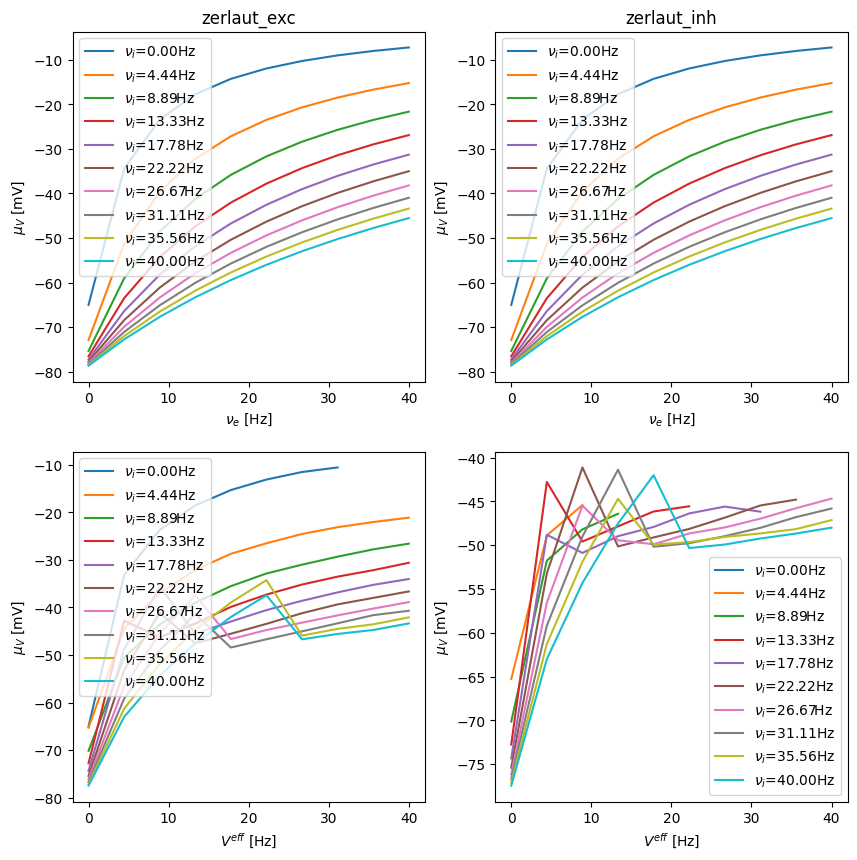

In [9]:
plt.figure(figsize=(10, 10))
for i, neuron_name in enumerate(neurons, start=1):
    # i labels the columns of the subplot (each column is for a given type of neurons)
    for j, nu_i in enumerate(nu_i_range):
        plt.subplot(2, 2, i)
        plt.plot(nu_e_range, mu_Vs[neuron_name][:,j], label=fr'$\nu_i$={nu_i:.2f}Hz')
        plt.subplot(2, 2, i+2)
        plt.plot(nu_e_range, v_effs[neuron_name][:,j], label=fr'$\nu_i$={nu_i:.2f}Hz')

    plt.subplot(2, 2, i)
    plt.legend()
    plt.xlabel(r'$\nu_e$ [Hz]')
    plt.ylabel(r'$\mu_V$ [mV]')
    plt.title(neuron_name)

    plt.subplot(2, 2, i+2)
    plt.legend()
    plt.xlabel(r'$V^{{eff}}$ [Hz]')
    plt.ylabel(r'$\mu_V$ [mV]')

plt.show()


Comments:
- $\mu_V$ is the same for exc and inh because the only difference in parameters is adaptation, and we did not take it into account


In [10]:
# Fitting V_eff

expansion_point = np.array([-60, 4e-3, 0.5])  # mV, mV, 1
expansion_norm = np.array([10e-3, 6e-3, 1.])  # mV, mV, 1
coefs_fit = dict()
for neuron_name in neurons:
    nnu_e, nnu_i = np.meshgrid(nu_e_range, nu_i_range, indexing='ij')
    act = activities[neuron_name]
    adapt = adaptations[neuron_name]
    v_eff = v_effs[neuron_name]
    mu_V = mu_Vs[neuron_name]
    sigma_V = sigma_Vs[neuron_name]
    tau_V = tau_Vs[neuron_name]
    tau_VN = tau_VNs[neuron_name]

    coefs_init = [1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3,1e-3]
    coefs = simulations.v_eff_curve_fit(coefs_init, v_eff, mu_V, sigma_V, tau_VN, expansion_point, expansion_norm)
    coefs_fit[neuron_name] = coefs

TODO:
- tau_V z dat
- porovnat tau_V, mu_V, sigma_V ze simulaci a z fitu
- V_eff zubate, proc?
- na zacatku heatmapa adaptace (jak je heat mapa aktivity)
- TF se chova divne pro nektere hodnoty!

In [11]:
# Fitting transfer function
tfs = dict()
nu_outs = dict()

for neuron_name, sim_pars in neurons.items():
    tf = simulations.get_transfer_function(coefs_fit[neuron_name], expansion_point, expansion_norm, sim_pars)
    tfs[neuron_name] = tf
    # NOTE: Zerlaut specific, ignoring adaptation (w=0)
    nu_outs[neuron_name] = tf(nu_e_range, nu_i_range, np.array([0.]))

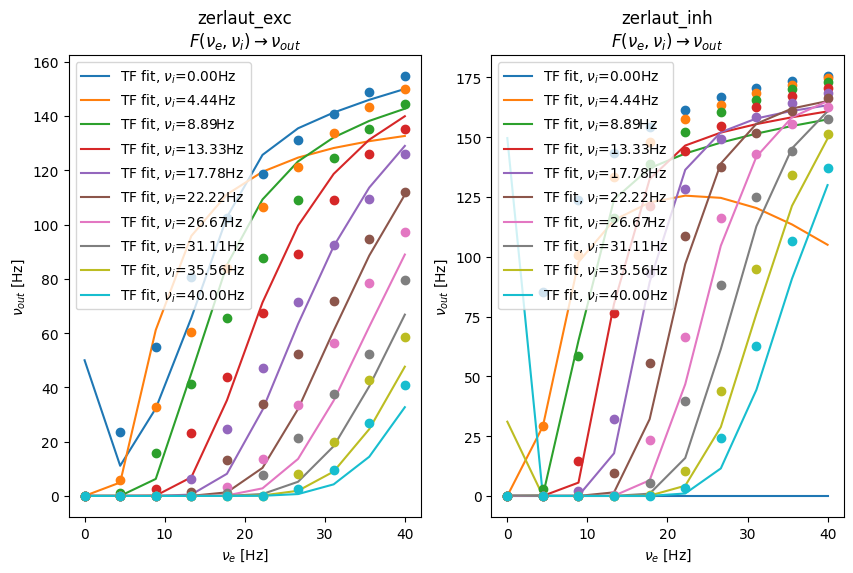

In [12]:
plt.figure(figsize=(10, 6))
for i, neuron_name in enumerate(neurons, start=1):
    # i labels the columns of the subplot (each column is for a given type of neurons)
    plt.subplot(1, 2, i)
    for j, nu_i in enumerate(nu_i_range):
        plt.plot(nu_e_range, nu_outs[neuron_name][:,j], '-', label=fr'TF fit, $\nu_i$={nu_i:.2f}Hz')
    plt.gca().set_prop_cycle(None)
    for j, nu_i in enumerate(nu_i_range):
        plt.plot(nu_e_range, activities[neuron_name][:,j], 'o')
    plt.legend()
    plt.xlabel(r'$\nu_e$ [Hz]')
    plt.ylabel(r'$\nu_{{out}}$ [Hz]')
    plt.title(f'{neuron_name}'+ '\n'+ r'$F(\nu_e,\nu_i)\to \nu_{out}$')
plt.show()

# Network

In [13]:
neuron_name = 'zerlaut_exc'
sim_pars = neurons[neuron_name]
sim_pars

{'neuron_params': {'v_rest': -65.0,
  'v_reset': -65.0,
  'tau_refrac': 5.0,
  'tau_m': 15.0,
  'cm': 0.15,
  'e_rev_E': 0.0,
  'e_rev_I': -80.0,
  'tau_syn_E': 5.0,
  'tau_syn_I': 5.0,
  'a': 4.0,
  'b': 0.02,
  'delta_T': 2.0,
  'tau_w': 500.0,
  'v_thresh': -50.0},
 'exc_syn_params': {'weight': 1.0, 'delay': 1.0},
 'inh_syn_params': {'weight': 5.0, 'delay': 1.0},
 'exc_syn_number': 400,
 'inh_syn_number': 100,
 'synapse_type': 'static_synapse',
 'simulation_time': 1000.0,
 'poisson_input': True}

In [ ]:
simulation_time = 1000  # ms
external_rate = 10  # Hz

exc_neuron = neurons['zerlaut_exc']
inh_neuron = neurons['zerlaut_inh']

dt = 0.1  # ms

sim.setup(timestep=dt)

# Setup network
exc_neurons = sim.Population(8000, sim.EIF_cond_exp_isfa_ista(**exc_neuron['neuron_params']))
inh_neurons = sim.Population(2000, sim.EIF_cond_exp_isfa_ista(**inh_neuron['neuron_params']))

connector = sim.FixedProbabilityConnector(p_connect=0.05)
synapse_exc = sim.native_synapse_type(exc_neuron['synapse_type'])(**exc_neuron['exc_syn_params'])
synapse_inh = sim.native_synapse_type(inh_neuron['synapse_type'])(**inh_neuron['inh_syn_params'])

sim.Projection(exc_neurons, exc_neurons, connector, synapse_type=synapse_exc, receptor_type='excitatory')
sim.Projection(exc_neurons, inh_neurons, connector, synapse_type=synapse_exc, receptor_type='excitatory')
sim.Projection(inh_neurons, exc_neurons, connector, synapse_type=synapse_inh, receptor_type='inhibitory')
sim.Projection(inh_neurons, inh_neurons, connector, synapse_type=synapse_inh, receptor_type='inhibitory')

exc_neurons.record(['v', 'spikes', 'w', 'gsyn_exc', 'gsyn_inh'])
inh_neurons.record(['v', 'spikes', 'w', 'gsyn_exc', 'gsyn_inh'])

# Setup external input

# rate should increase slowly not to cause too much spike synchrony
rate = np.linspace(0, external_rate, int(100/dt)+1)
rate = np.concatenate((rate, np.ones(int(simulation_time/dt) + 1 - rate.size)*external_rate))
spikes = np.random.rand(rate.size, 8000) < rate[:, np.newaxis]*dt/1000
spike_times = [np.where(sp)[0] * dt for sp in spikes.T]
external_input = sim.Population(8000, sim.SpikeSourceArray(spike_times=spike_times))

sim.Projection(external_input, exc_neurons, connector, synapse_type=synapse_exc, receptor_type='excitatory')
sim.Projection(external_input, inh_neurons, connector, synapse_type=synapse_exc, receptor_type='excitatory')

sim.run(simulation_time)



TypeError: `synapse_type` should be an instance of a subclass of BaseSynapseType. The argument provided was of type 'str'

# Mean-Field